In [2]:
from __future__ import division
from pylab import *
from timml import *
%matplotlib inline

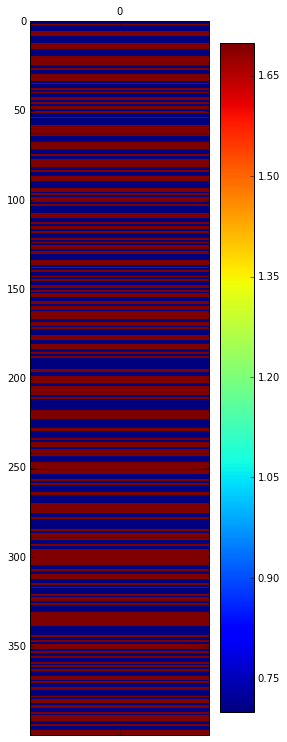

In [3]:
k = hstack((5 * ones(20), 50 * ones(20)))
kaq = np.empty((10, 40))
for i in range(10):
    kaq[i] = choice(k, 40, replace=False)
figure(figsize=(5,5))
matshow(log10(kaq.flatten()[:,newaxis]), aspect=0.01)
colorbar()
xticks();

In [4]:
def model(seed=10, areasink=False, returnmodel=False):
    np.random.seed(seed)
    k = hstack((5 * ones(20), 50 * ones(20)))
    kaq = np.empty((10, 40))
    for i in range(10):
        kaq[i] = choice(k, 40, replace=False)
    ml = Model3D(kaq=kaq.flatten(), z=linspace(0, -40, 401), kzoverkh=1.0)
    w = Well(ml, 0, 0, Qw=1000, rw=0.3, layers=range(360, 400))
    if areasink:
        c = CircAreaSink(ml, 0, 0, 1000, 0.001 / np.pi)
    rf = Constant(ml, 1000, 0, 100)
    ml.solve(silent=True)
    if returnmodel: return ml
    return ml.head(0.3, 0, ml.aq.Naq - 1)

head at well: 94.5711870927


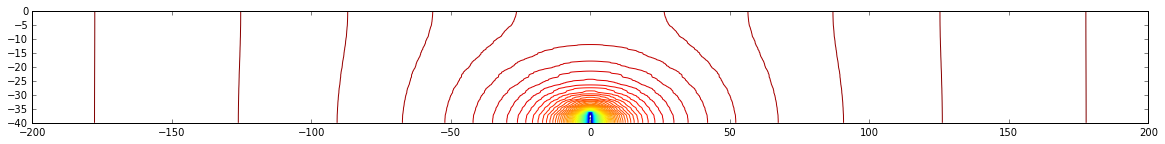

In [5]:
ml = model(areasink=False, returnmodel=True)
print 'head at well:', ml.head(0.3, 0, 399)
x = np.linspace(-200, 200, 400)
h = ml.headalongline(x, 0)
figure(figsize=(20, 40))
contour(x, arange(-0.05, -40, -0.1), h, 100)
axis('image');

(-200.0, 200.0, -40.0, 0.0)

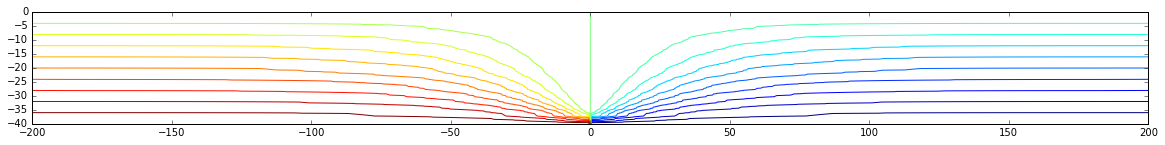

In [6]:
qx = np.zeros((400, 400))
for i in range(len(x)):
    qx[:, i] = ml.disvec(x[i], 0)[0] * 2 * np.pi * abs(x[i])
psi = np.zeros((401, 400))
psi[1:, :] = np.cumsum(qx, 0)
figure(figsize=(20, 40))
contour(x, arange(0, -40.01, -0.1), psi, 20)
axis('image')

head at well: 94.642833037


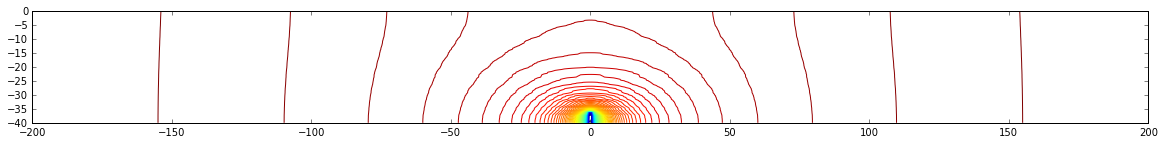

In [7]:
ml = model(areasink=True, returnmodel=True)
print 'head at well:', ml.head(0.3, 0, 399)
x = np.linspace(-200, 200, 400)
h = ml.headalongline(x, 0)
figure(figsize=(20, 40))
contour(x, arange(-0.05, -40, -0.1), h, 100)
axis('image');

(-200.0, 200.0, -40.0, 0.0)

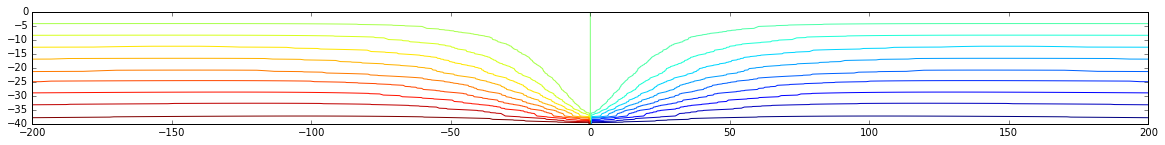

In [8]:
qx = np.zeros((400, 400))
for i in range(len(x)):
    qx[:, i] = ml.disvec(x[i], 0)[0] * 2 * np.pi * abs(x[i])
psi = np.zeros((401, 400))
psi[1:, :] = np.cumsum(qx, 0)
figure(figsize=(20, 40))
contour(x, arange(0, -40.01, -0.1), psi, 20)
axis('image')

In [9]:
def modelaniso(kzoverkh, kaq, value, areasink=False, logscale=False):
    if logscale: 
        kzoverkh = 10.0 ** kzoverkh
    ml2 = Model3D(kaq=kaq, z=linspace(0, -40, 401), kzoverkh=kzoverkh * ones(400))
    w = Well(ml2, 0, 0, Qw=1000, rw=0.3, layers=range(360, 400))
    if areasink:
        c = CircAreaSink(ml, 0, 0, 1000, 0.001 / np.pi)
    rf = Constant(ml2, 1000, 0, 100)
    ml2.solve(silent=True)
    return ml2.head(0.3, 0, layers=ml2.aq.Naq - 1) - value

In [11]:
from scipy.optimize import bisect
N = 10
kzoverkh = np.empty(N)
for i in range(N):
    print 'model', i
    ml = model(seed=i, areasink=0, returnmodel=1)
    kaq = np.sum(ml.aq.T) / np.sum(ml.aq.Haq)
    hw = ml.head(0.3, 0, ml.aq.Naq - 1)
    kaniso = bisect(modelaniso, 0.05, 1, args=(kaq, hw, 1), xtol=1e-3, rtol=1e-3)
    #kaniso = bisect(modelaniso, -3, -1, args=(kaq, hw, 1, 1), xtol=1e-3, rtol=1e-3)
    kzoverkh[i] = kaniso

model 0
model 1
model 2
model 3
model 4
model 5
model 6
model 7
model 8
model 9


In [12]:
1 / kzoverkh

array([ 2.92989986,  2.56705941,  3.17126045,  2.72268014,  2.66875163,
        2.86754411,  2.77883311,  2.72268014,  3.85107183,  3.59424359])

In [28]:
ml = model(seed=10, areasink=0, returnmodel=1)
kaq = np.sum(ml.aq.T) / np.sum(ml.aq.Haq)
hw = ml.head(0.3, 0, ml.aq.Naq - 1)
kaniso = bisect(modelaniso, 0.006, 0.1, args=(kaq, hw, 0), xtol=1e-3, rtol=1e-3)
print 'kaniso no area-sink', kaniso, 1/kaniso
ml = model(seed=10, areasink=1, returnmodel=1)
kaq = np.sum(ml.aq.T) / np.sum(ml.aq.Haq)
hw = ml.head(0.3, 0, ml.aq.Naq - 1)
kaniso = bisect(modelaniso, 0.006, 0.1, args=(kaq, hw, 1), xtol=1e-3, rtol=1e-3)
print 'kaniso with area-sink', kaniso, 1/kaniso

kaniso no area-sink 0.011140625 89.7615708275
kaniso with area-sink 0.012609375 79.3060718711


In [60]:
from scipy.optimize import fsolve
N = 1
kzoverkh = np.empty(N)
for i in range(N):
    print 'model', i
    ml = model(areasink=0, returnmodel=1)
    kaq = np.sum(ml.aq.T) / np.sum(ml.aq.Haq)
    hw = ml.head(0.3, 0, ml.aq.Naq - 1)
    kaniso = fsolve(modelaniso, -1, args=(kaq, hw, 1, 1), xtol=1e-3)
    kzoverkh[i] = 10 ** kaniso

model 0
kzoverkh: [ 0.1]
kzoverkh: [ 0.1]
kzoverkh: [ 0.1]
kzoverkh: [ 0.1]
kzoverkh: [ 0.03140342]
kzoverkh: [ 0.03123678]
kzoverkh: [ 0.03123607]


In [24]:
hwell = np.zeros(100)
for i in range(100):
    hwell[i] = model(seed=i)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


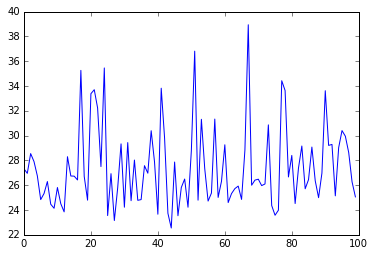

In [25]:
plot(hwell)

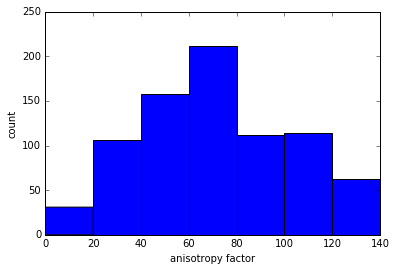

In [21]:
hist(1.0/kzoverkh, bins=arange(0, 160, 20))
xlabel('anisotropy factor')
ylabel('count')
savefig('anisotropy_histogram.png')

In [ ]:
for i in range(300):
    print 'model', i
    k = hstack((0.01 * ones(10), 0.1 * ones(10), 1 * ones(10), 10 * ones(10)))
    kaq = np.empty((10, 40))
    for i in range(10):
        kaq[i] = choice(k, 40, replace=False)
    ml = Model3D(z = linspace(0, -40, 401), kh = kaq.flatten(), kzoverkh=1.0)
    w = Well(ml, 0, 0, Qw=1000, rw=0.3, layers=range(360, 400))
    rf = Constant(ml, 1000, 0, 100)
    ml.solve(silent=True)


In [ ]:
ml.aq.T

In [ ]:
for i in range(1):
    print 'model', i
    k = hstack((0.01 * ones(10), 0.1 * ones(10), 1 * ones(10), 10 * ones(10)))
    kaq = np.empty((10, 40))
    for i in range(10):
        kaq[i] = choice(k, 40, replace=False)
    ml = Model3D(z = linspace(0, -40, 401), kh = kaq.flatten(), kzoverkh=1.0)
    w = Well(ml, 0, 0, Qw=1000, rw=0.3, layers=range(360, 400))
    rf = Constant(ml, 1000, 0, 100)
    ml.solve(silent=True)

In [ ]:
ml2.aq.lab.real

ml2.aq.eigvec

In [ ]:
ml2.aq.eigvec.dtype

In [ ]:
ml2.aq.lab.dtype == 'complex128'

In [ ]:
W, U = ml.aq.systemMatrix()

In [ ]:
W.dtype

In [ ]:
if W.dtype == 'complex128':
    print 'HELLO'
    if abs(W.imag).max < 1e-12:  # Quick fix for possibly small imaginary parts
        print 'Warning: tiny imaginary part of W neglected'
        W = W.real

In [ ]:
abs(W.imag).max < 1e-12

In [ ]:
W.imag.max()

In [22]:
mean(1.0/kzoverkh)

71.933756220946535

In [23]:
savetxt('anisotropy_factor.txt', 1.0/kzoverkh)

In [24]:
percentile(1.0/kzoverkh, [5, 95])

array([  23.01330457,  121.9047619 ])

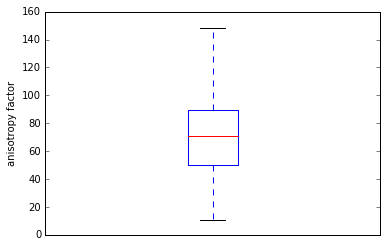

In [27]:
boxplot(1.0 / kzoverkh)
xticks([])
ylabel('anisotropy factor')
savefig('anisotropy_boxplot.png')

In [48]:
def modelbram(returnmodel=False):
    k = hstack((5 * ones(10), 15 * ones(10), 25 * ones(10), 35 * ones(10)))
    #k = hstack((15 * ones(10), 15 * ones(10), 15 * ones(10), 15 * ones(10)))
    kaq = np.empty((10, 40))
    for i in range(10):
        kaq[i] = choice(k, 40, replace=False)
    ml = Model3D(z = linspace(0, -40, 401), kh = kaq.flatten(), kzoverkh=1.0)
    w = Well(ml, 0, 0, Qw=1000, rw=0.3, layers=range(360, 400))
    rf = Constant(ml, 1000, 0, 100)
    ml.solve(silent=True)
    if returnmodel: return ml
    return ml.head(399, 0.3, 0)

In [49]:
ml = modelbram(1)
ml.aq.Tcomp

799.99999999999943

In [50]:
def modelbramaniso(kzoverkh, value, returnmodel=False):
    ml2 = Model3D(z = linspace(0, -40, 401), kh = 20, kzoverkh=kzoverkh * ones(400))
    w = Well(ml2, 0, 0, Qw=1000, rw=0.3, layers=range(360, 400))
    rf = Constant(ml2, 1000, 0, 100)
    ml2.solve(silent=True)
    if returnmodel: return ml2
    return ml2.head(399, 0.3, 0) - value

In [51]:
from scipy.optimize import bisect
N = 2
kzoverkh = np.empty(N)
for i in range(N):
    print 'model', i
    hw = modelbram()
    kaniso = bisect(modelbramaniso, 0.1, 20, args=(hw,), xtol=1e-3, rtol=1e-3)
    kzoverkh[i] = kaniso

model 0
model 1


In [38]:
ml1 = modelbram(1)

In [39]:
ml2 = modelbramaniso(1.0, 10, 1)

In [40]:
ml1.head(399, 0, 0.3)

91.790040940159628

In [41]:
ml2.head(399, 0, 0.3)

91.790040940159628

In [52]:
kzoverkh

array([ 0.78017578,  0.54697266])

In [53]:
1.0 / kzoverkh

array([ 1.28176242,  1.82824496])

In [67]:
200 / np.pi / 200 **2

0.0015915494309189533

In [68]:
1000 / np.pi / 1000 ** 2

0.0003183098861837907

In [70]:
0.001 / np.pi

0.0003183098861837907

In [82]:
ml1 = model(areasink=0, returnmodel=1)

In [83]:
ml2 = model(areasink=1, returnmodel=1)

In [89]:
1000.0 / ml.aq.lab.min()

19999.906256555998

In [90]:
from scipy.special import i0

In [91]:
i0(2e5)

inf

In [94]:
c = ml2.elementList[1]

In [95]:
c.isLargeCircle

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

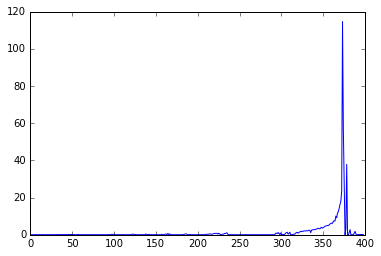

In [97]:
plot(ml2.aq.lab)

grid of (50, 400). gridding in progress. hit ctrl-c to abort


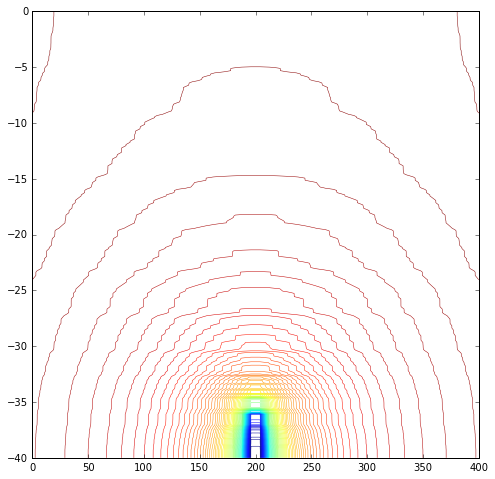

In [101]:
timvertcontour(ml1, -200, 0, 200, 0, 50, -40, 0, 400, levels=100)

In [105]:
x = np.linspace(-1000, 1000, 200)
h1 = zeros_like(x)
h2 = zeros_like(x)
for i in range(len(x)):
    h1[i] = ml1.head(0, x[i], 0)
    h2[i] = ml2.head(0, x[i], 0)

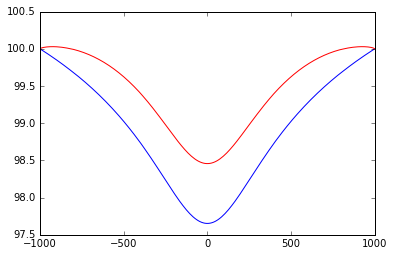

In [106]:
plot(x, h1)
plot(x, h2, 'r')

In [108]:
qx, qy = ml1.dischargeVector(1000, 0)

In [110]:
sum(qx)

-0.15915494309189537

In [111]:
0.001 / np.pi * 1000 ** 2 * np.pi

1000.0

In [112]:
1000 / 2 / np.pi / 1000

0.15915494309189535

In [121]:
qx, qy = ml2.dischargeVector(950, 0)

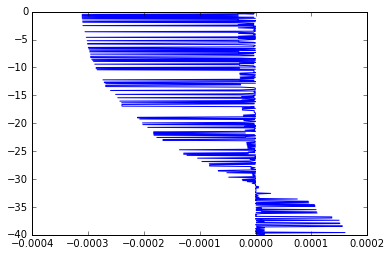

In [122]:
plot(qx, np.linspace(-40, 0, 400))